# KDD: Bank Marketing (Term Deposit Subscription)



This notebook implements the **KDD methodology** — **Selection → Preprocessing → Transformation → Data Mining → Interpretation/Evaluation** — on the classic **Bank Marketing** dataset (`bank-additional-full.csv`).

**Goal:** Predict whether a client will subscribe to a term deposit (`y`) and discover meaningful customer patterns.


# Phase 1: Selection

**Objectives**
- Load the dataset and verify schema
- Identify target (`y`) and candidate predictors
- Decide on exclusions (e.g., leakage features)

**Notes**
- The column `duration` (last contact duration) is **leakage**: it is known only after the call is made and correlates strongly with outcome. We **exclude it** from modeling.


In [1]:
# Load data directly
import os, pandas as pd

data_path = "/content/bank_marketing_dataset/bank-additional-full.csv"

# Check if the path exists before loading
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}. Please ensure it is in the correct location.")

df = pd.read_csv(data_path, sep=';')

print("Loaded data from:", data_path)
print("Shape:", df.shape)
df.head()

Loaded data from: /content/bank_marketing_dataset/bank-additional-full.csv
Shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2]:
# Inspect schema and target
print(df.info())
print("\nTarget distribution (y):")
print(df['y'].value_counts())
print(df['y'].value_counts(normalize=True))

TARGET_COL = 'y'
LEAKAGE_COLS = [c for c in df.columns if c.lower() == 'duration']
print("\nLeakage columns to drop:", LEAKAGE_COLS)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

# Phase 2: Preprocessing

**Objectives**
- Handle missing/unknown values
- Encode categoricals, standardize numeric features
- Split data into train/validation sets (stratified)

**Plan**
- Treat `"unknown"` as missing for categoricals where present.
- One-hot encode categoricals; scale numeric features.
- Stratified split to preserve the minority positive class.


In [3]:
# Basic cleaning
import numpy as np

df_clean = df.copy()

# Replace "unknown" with NaN for categoricals
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].replace("unknown", np.nan)

# Drop leakage columns
df_clean = df_clean.drop(columns=LEAKAGE_COLS, errors='ignore')

# Separate features/target
X_full = df_clean.drop(columns=[TARGET_COL])
y_full = df_clean[TARGET_COL].map({'yes':1, 'no':0}) if df_clean[TARGET_COL].dtype == 'object' else df_clean[TARGET_COL]

print("Features shape:", X_full.shape, "Target positive rate:", y_full.mean())

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print("Train:", X_train.shape, "Valid:", X_valid.shape)

Features shape: (41188, 19) Target positive rate: 0.11265417111780131
Train: (32950, 19) Valid: (8238, 19)


In [5]:
# Build preprocessing pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

print("Numeric columns:", num_cols[:10], "... total", len(num_cols))
print("Categorical columns:", cat_cols[:10], "... total", len(cat_cols))

Numeric columns: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'] ... total 9
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'] ... total 10


# Phase 3: Transformation

**Objectives**
- Create useful derived features
- Optional: balance the classes or adjust decision thresholds
- Prepare data for mining (sparse-friendly)

**Plan**
- Keep transformation light to avoid leakage.
- Optionally add interactions (e.g., `age × campaign`) or binning for monotonicity.
- Consider class handling via `class_weight='balanced'` rather than resampling.


In [7]:
# Simple feature engineering
import numpy as np
import pandas as pd

X_train_fe = X_train.copy()
X_valid_fe = X_valid.copy()

def add_features(df):
    if "campaign" in df.columns:
        df["campaign_capped"] = np.minimum(df["campaign"], 10)
    if "pdays" in df.columns:
        df["pdays_missing"] = (df["pdays"] == 999).astype(int)
        df["pdays_clipped"] = np.where(df["pdays"] == 999, np.nan, np.minimum(df["pdays"], 30))
    return df

X_train_fe = add_features(X_train_fe)
X_valid_fe = add_features(X_valid_fe)

num_cols = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train_fe.select_dtypes(exclude=[np.number]).columns.tolist()

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])
preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

print("After FE - numeric cols:", len(num_cols), "categorical cols:", len(cat_cols))

After FE - numeric cols: 12 categorical cols: 10


# Phase 4: Data Mining

**Objectives**
- Train predictive models for subscription (`y`)
- Use stratified CV; focus on **ROC AUC** and **PR AUC** due to class imbalance
- Optionally explore **unsupervised** patterns (customer segments via KMeans)

**Models**
- Logistic Regression (with class weight)
- Random Forest
- Gradient Boosting (strong tabular baseline)

We also include **KMeans clustering** on a reduced representation (TruncatedSVD) for segments.


LogReg ROC AUC (5-fold): mean=0.790 ± 0.005 | PR AUC: mean=0.443 ± 0.009


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RF ROC AUC (5-fold): mean=0.771 ± 0.008 | PR AUC: mean=0.413 ± 0.011
GB ROC AUC (5-fold): mean=0.794 ± 0.004 | PR AUC: mean=0.465 ± 0.011

Selected model: GB
Validation ROC AUC: 0.810 | PR AUC: 0.482


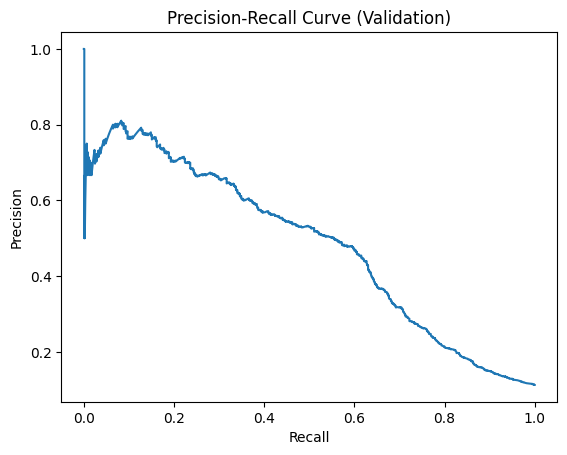

In [8]:
# Supervised models with CV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

models = {
    "LogReg": LogisticRegression(max_iter=500, class_weight="balanced", random_state=42),
    "RF": RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced_subsample"),
    "GB": GradientBoostingClassifier(random_state=42)
}

results = {}
for name, clf in models.items():
    pipe = Pipeline([("preprocessor", preprocessor_fe), ("clf", clf)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc = cross_val_score(pipe, X_train_fe, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)
    pr  = cross_val_score(pipe, X_train_fe, y_train, scoring="average_precision", cv=cv, n_jobs=-1)
    results[name] = {"ROC AUC": auc, "PR AUC": pr}
    print(f"{name} ROC AUC (5-fold): mean={auc.mean():.3f} ± {auc.std():.3f} | PR AUC: mean={pr.mean():.3f} ± {pr.std():.3f}")

best_name = max(results, key=lambda k: results[k]['ROC AUC'].mean())
best_clf = models[best_name]
best_pipe = Pipeline([("preprocessor", preprocessor_fe), ("clf", best_clf)])
best_pipe.fit(X_train_fe, y_train)

proba_valid = best_pipe.predict_proba(X_valid_fe)[:,1]
roc = roc_auc_score(y_valid, proba_valid)
pr_auc = average_precision_score(y_valid, proba_valid)
print(f"\nSelected model: {best_name}")
print(f"Validation ROC AUC: {roc:.3f} | PR AUC: {pr_auc:.3f}")

# Precision-Recall curve
import matplotlib.pyplot as plt
prec, rec, thr = precision_recall_curve(y_valid, proba_valid)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.show()

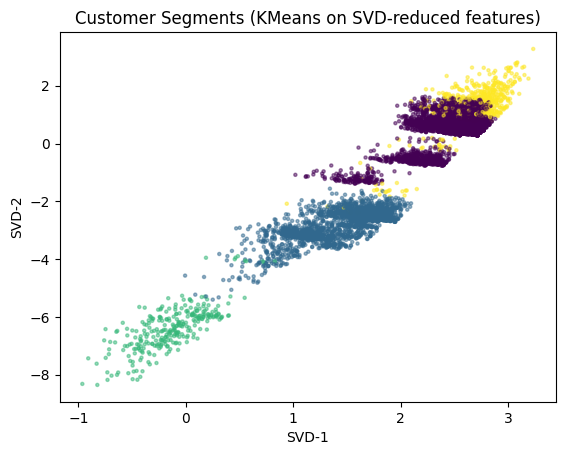

Conversion rate by segment:
segment
2    0.647059
1    0.208105
3    0.044850
0    0.044395
Name: y, dtype: float64


In [9]:
# Unsupervised: KMeans segments on SVD-reduced transformed features
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Xt_train = preprocessor_fe.fit_transform(X_train_fe)
Xt_valid = preprocessor_fe.transform(X_valid_fe)

svd = TruncatedSVD(n_components=10, random_state=42)
Z_train = svd.fit_transform(Xt_train)
Z_valid = svd.transform(Xt_valid)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(Z_train)
labels_valid = kmeans.predict(Z_valid)

Z2 = Z_valid[:, :2]
plt.figure()
plt.scatter(Z2[:,0], Z2[:,1], c=labels_valid, s=5, alpha=0.5)
plt.title("Customer Segments (KMeans on SVD-reduced features)")
plt.xlabel("SVD-1"); plt.ylabel("SVD-2")
plt.show()

seg_df = pd.DataFrame({"segment": labels_valid, "y": y_valid.values})
print("Conversion rate by segment:")
print(seg_df.groupby("segment")["y"].mean().sort_values(ascending=False))

# Phase 5: Evaluation

**Objectives**
- Explain model behavior and key drivers
- Validate business utility and risks
- Provide actionable insights for marketing

**Plan**
- Permutation importance to rank features
- Threshold sweep to balance precision/recall
- Segment-level insights


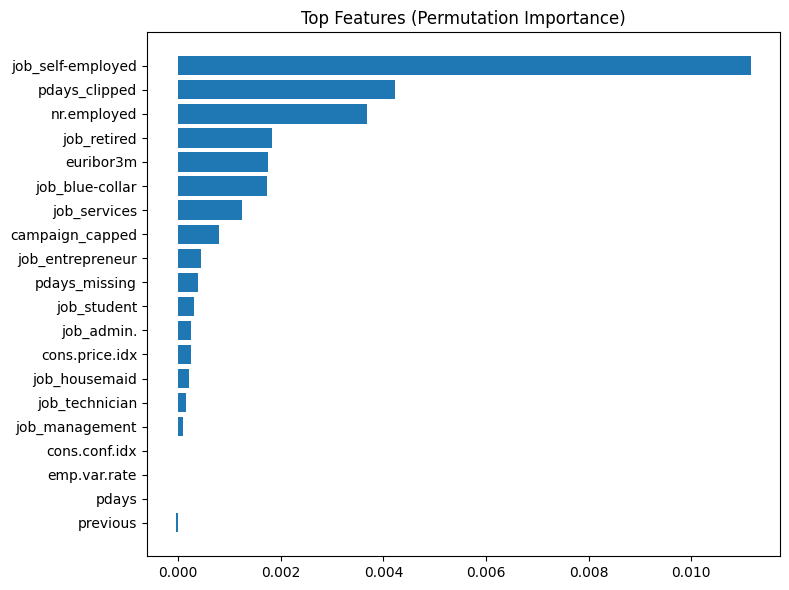

   threshold  precision    recall        f1
0       0.05   0.154105  0.887931  0.262629
1       0.10   0.353541  0.672414  0.463424
2       0.15   0.439636  0.623922  0.515813
3       0.20   0.475945  0.596983  0.529637
4       0.25   0.495256  0.562500  0.526741


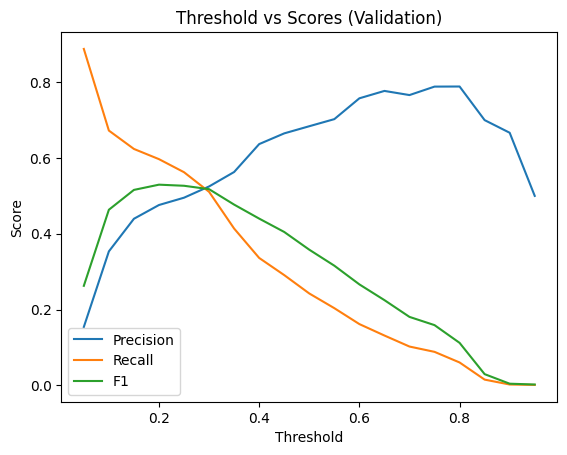

In [10]:
# Permutation Importance + Threshold Sweep
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score

result = permutation_importance(best_pipe, X_valid_fe, y_valid, n_repeats=5, random_state=42, n_jobs=-1)
importances = result.importances_mean

oh = best_pipe.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
num_names = best_pipe.named_steps["preprocessor"].transformers_[0][2]
cat_names = oh.get_feature_names_out(best_pipe.named_steps["preprocessor"].transformers_[1][2])
feat_names = list(num_names) + list(cat_names)

idx = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(8,6))
plt.barh([feat_names[i] for i in idx][::-1], importances[idx][::-1])
plt.title("Top Features (Permutation Importance)")
plt.tight_layout()
plt.show()

thrs = np.linspace(0.05, 0.95, 19)
rows = []
proba = proba_valid
for t in thrs:
    pred = (proba >= t).astype(int)
    rows.append([t,
                 precision_score(y_valid, pred, zero_division=0),
                 recall_score(y_valid, pred, zero_division=0),
                 f1_score(y_valid, pred, zero_division=0)])
thr_df = pd.DataFrame(rows, columns=["threshold","precision","recall","f1"])
print(thr_df.head())

plt.figure()
plt.plot(thr_df["threshold"], thr_df["precision"], label="Precision")
plt.plot(thr_df["threshold"], thr_df["recall"], label="Recall")
plt.plot(thr_df["threshold"], thr_df["f1"], label="F1")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Threshold vs Scores (Validation)")
plt.legend()
plt.show()